# Problem Set 1 (93 points) 

## Important information
We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

# Problem 1 (Theoretical tasks)  (36 pts)

_1._
- (1 pts) what are the constants $C_1$ and $C_2$ such that $C_1 \|x\|_{2} \leq \|x\|_{\infty} \leq C_2 \| x\|_{2}$ for any vector $x$
- (5 pts) Prove that $\| U A \|_F = \| A U \|_F = \| A \|_F$ for any unitary matrix $U$.
- (5 pts) Prove that $\| U A \|_2 = \| A U \|_2 = \| A \|_2$ for any unitary matrix $U$.
  
_2._
- (5 pts) Using the results from the previous subproblem, prove that $\| A \|_F \le \sqrt{\mathrm{rank}(A)} \| A \|_2$. _Hint:_ SVD will help you.
- (5 pts) Show that for any $m, n$ and $k \le \min(m, n)$ there exists $A \in \mathbb{R}^{m \times n}: \mathrm{rank}(A) = k$, such that $\| A \|_F = \sqrt{\mathrm{rank}(A)} \| A \|_2$. In other words, show that the previous inequality is not strict.
- (5 pts) Prove that if $\mathrm{rank}(A) = 1$, then $\| A \|_F  = \| A \|_2$.
- (5 pts) Prove that $\| A B \|_F \le \| A \|_2 \| B \|_F$.

_3._

- (2 pts) Let $U \in \mathbb{C}^{n \times k}, k < n$ be a matrix so that $U^*U = I_k$. 
Find a pseudoinverse of $UU^*$
- (3 pts) Compute SVD of the matrix analytically, i.e. provide the analytical expression for every natural $n$ 

$$
A = \begin{bmatrix}
1\\
\sqrt{3}\\
\sqrt{5}\\
\vdots\\
\sqrt{2n-1}
\end{bmatrix}
\begin{bmatrix}
-1 & 1 & -1 & \ldots & (-1)^{n}
\end{bmatrix}
$$

In [ ]:
# Your solution is here

# Problem 2 (Matrix calculus) (12 pts)

_1._ (10 pts) Consider the following function

$$ F(U, V) = \frac{1}{2}\|X - UV\|_F^2, $$

where $X \in \mathbb{R}^{n \times n}$, $U \in \mathbb{R}^{n \times k}$ and $V \in \mathbb{R}^{k \times n}$ and $k < n$. 

- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $U$ 
- (2 pts) Derive analytical expression for the gradient of the function $F$ with respect to $V$
- (6 pts) Estimate computational complexity of computing these gradients (in big-O notation). Also, compare timing of analytical computations versus timing the automatic differentiation with JAX. Study some range of dimensions to extract asymptotic complexity and make a conclusion, what approach is faster. Plot the dependence of running time on the dimension (row and column separately) to proof your conclusion 

_2._ (2 pts) Derive analytical expression for the gradient of the function $f$:

$$ R(x) = \frac{(Ax, x)}{(x, x)}, $$

where $A$ is a symmetric real matrix. Why the gradient of this function is important in NLA you will know in the lectures later.

In [ ]:
# Your solution is here

# Problem 3. Compression of the fully-connected layers in neural network with simple architecture (30 pts)

In this problem we consider the neural network that performs classification of the dataset of images. 
Any neural network can be considered as composition of simple linear and non-linear functions.
For example, a neural network with 3 layers can be represented as 

$$f_3(f_2(f_1(x, w_1), w_2), w_3),$$

where $x$ is input data (in our case it will be images) and $w_i, \; i =1,\dots,3$ are parameters that are going to be trained. 

We will study the compression potential of neural network with simple architecture: alternating some numbers of linear and non-linear functions. 

The main task in this problem is to study how the compression of fully-connected layers affects the test accuracy.
Any fully-connected layer is represented as linear function $AX + B$, where $X$ is input matrix and $A, B$ are trainable matrices. Matrices $A$ in every layer are going to be compressed.
The main result that you should get is the plot of dependence of test accuracy on the total number of parameters in the neural network.

#### Zero step: install PyTorch

- Follow the steps in [official instructions](https://pytorch.org/get-started/locally/)

#### First step: download CIFAR10 dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Check what images are we going to classify

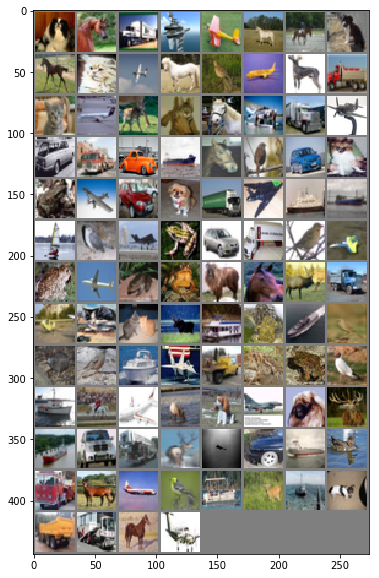

  dog horse truck plane plane horse horse   dog


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Second step: neural network architecture

For simplicity and demonstration purposes of the neural network compression idea consider the architecture consisting of the only fully-connected layers and non-linear ReLU functions between them.
To demonstrate compression effect, consider the dimension of the inner layers equals to 1000.

Below you see implementation of such neural network in PyTorch.
More details about neural networks you will study in the *Deep learning* course in one of the upcoming term

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

#### Implement functions for training and testing after every sweep over all dataset entries

In [5]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [6]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Set parameters for training and print intermediate loss values

In [7]:
log_interval = 50
epochs = 7

### Third step: run training with the [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) optimization method

If your laptop is not very fast, you will wait some time till training is finished. 

In [8]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303509
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.017663
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.012401
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.880147
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.677673
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.762426
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.699280
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.811280
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.371416
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.669703

Test set: Average loss: 1.5764, Accuracy: 4378/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.346880
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.285201
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.515415
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.770635
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.582595
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.431566
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.358462
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.410893
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.661417
T

Now we have somehow trained neural network and we are ready to perform compression of the weigths in the fully-connected layers.

- (3 pts) Compute SVD of the matrix $1000 \times 1000$, which corresponds to a weight matrix $A$ in any layer of the trained neural network of the appropriate dimension. To find more information about accessing this matrix please refer to [PyTorch manual](https://pytorch.org/docs/stable/index.html).
Plot decaying of the singular values like it was shown in the lecture. What conclusion can you make?
- (17 pts) Create a new model, which is an analogue to the class ```Net```, but with some significant distinctions. 
It takes as input parameters the instance of the class ```Net``` and compression rank $r > 0$. 
After that, this model has to compress all matrices $A$ in fully-connected layers with SVD using first $r$ singular vectors and singular values.
Pay attention to efficient storing of compress representation of the layers.
Also ```forward``` method of your new model has to be implemented in a way to use compressed representation of the fully-connected layers in the most efficient way. In all other aspects it has to reproduce ```forward``` method in the original non-compressed model (number of layers, activations, loss function etc).
- (5 pts) Plot dependence of test accuracy on the number of parameters in the compressed model. This number of parameters obviously depends on the compression rank $r$.
Also plot dependence of time to compute inference on the compression rank $r$.
Explain obtained results.
To measure time, use [%timeit](https://docs.python.org/3.6/library/timeit.html) with necessary parameters (examples of using this command see in lectures) 

- (5 pts) After such transformations, your model depends on the factors obtained from SVD. Therefore, these factors are also can be trained with the same gradient method during some number of epochs. This procedure is called fine-tuning. We ask you make this fine-tuning of your compressed model during from 1 to 5 epoch and compare the result test accuracy with the test accuracy that you get after compression. Explain the observed results 

In [ ]:
# Your solution is here

## Problem 4. «Reducio!» (15 pts)  

Hermione Granger is well versed in all magical disciplines. In particular, she is a great expert in Numerical Linear Algebra and JAX.

She has invited Harry Potter to play the game. 

Hermione chooses a number $r \in [1, 95]$ and two matrices $W_1 \in \mathbb{R}^{r \times 100}$ and $W_2 \in \mathbb{R}^{100 \times r}$.
Harry can tell her any 100-dimensional vector $x$, and Hermione gives Harry the result of 

$$
\sin(W_2 \cos(W_1 x)),$$ 

where trigonometric functions are applied element-wise. 
This result is also a 100-dimensional vector. 

Not to lose, Harry should guess what number $r$ Hermione has chosen.   
Harry knows the python language, but he is an absolute layman in algebra. Please, help him to get at least 95% correct answers! 

<i> Hint 1: SVD might help you, but use it wisely! </i>

<i> Hint 2: Suppose that a special magic allows you to compute gradients through automatic differentiation in JAX. You can also estimate gradients via finite differences, if you want it.</i>

<i> Hint 3: You can estimate the matrix rank using simple heuristics.
    
You should write code into the `harry_answers` function. Good luck! 

In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import random

class Game:
    def __init__(self, key):
        # key is a jax.random.PRNGKey
        self.key = key
        return
    def hermione_chooses_r_and_W(self):
        self.r = random.randint(1, 95)
        self.key, subkey = jax.random.split(self.key)
        self.W1 = jax.random.uniform(subkey, (self.r, 100), maxval=100., minval=0., dtype=jnp.float32)
        self.key, subkey = jax.random.split(self.key)
        self.W2 = jax.random.uniform(subkey, (100, self.r), maxval=100., minval=0., dtype=jnp.float32)
    def hermione_computes_function(self, x):
        return jnp.sin(self.W2 @ jnp.cos(self.W1 @ x))
    def harry_answers(self):
        # <your code here>
        # you shouldn't use self.r, self.W1, or self.W2
        # you can call `hermione_computes_function` multiple times
        r = 1 # for example
        return r
    
    def play(self, n_rounds, verbose=True):
        # n_rounds: a number of rounds of the game
        # verbose: print or not the result of each round
        n_right_answers = 0
        for _ in range(n_rounds):
            self.hermione_chooses_r_and_W()
            r = self.harry_answers()
            if abs(r - self.r) == 0:
                if verbose:
                    print("Good job! The true answer is {}, Harry's answer is {}!".format(self.r, r))
                n_right_answers += 1
            else:
                if verbose:
                    print("Harry's answers is {}, but the true answer is {} :(".format(r, self.r))
        if float(n_right_answers) / n_rounds > 0.95:
            print('Well done: {}/{} right answers!'.format(n_right_answers, n_rounds))
        else:
            print('Only {}/{} right answers :( Work a little more and you will succeed!'.format(
                n_right_answers, n_rounds))

In [2]:
key = jax.random.PRNGKey(713)
game = Game(key)
game.play(n_rounds=100, verbose=False)

/Users/alex/anaconda3/envs/pytorch/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Only 1/100 right answers :( Work a little more and you will succeed!


# Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```